<a href="https://colab.research.google.com/github/RoboDoig/DeepLabCut/blob/master/ml_stretch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Dataset

In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls PetImages/Cat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  32.1M      0  0:00:24  0:00:24 --:--:-- 32.5M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y
0.jpg	   11608.jpg  1966.jpg	3573.jpg  5180.jpg  6789.jpg  8396.jpg
10000.jpg  11609.jpg  1967.jpg	3574.jpg  5181.jpg  678.jpg   8397.jpg
10001.jpg  1160.jpg   1968.jpg	3575.jpg  5182.jpg  6790.jpg  8398.jpg
10002.jpg  11610.jpg  1969.jpg	3576.jpg  5183.jpg  6791.jpg  8399.jpg
10003.jpg  11611.jpg  196.jpg	3577.jpg  5184.jpg  6792.jpg  839.jpg
10004.jpg  11612.jpg  1970.jpg	3578.jpg  5185.jpg  6793.jpg  83.jpg
10005.jpg  11613.jpg  1971.jpg	3579.jpg  5186.jpg  6794.jpg  8400.jpg
10006.jpg  11614.jpg  1972.jpg	357.jpg   5187.jpg  6795.jpg  8401.jpg
10007.jpg  11615.jpg  1973.jpg	3580.jpg  5188.jpg  6796.jpg  8402.jpg
10008.jpg  11616.jpg  1974.jpg	3581.jpg  5189.jpg  6797.jpg  8403.jp

# Filter images (corruption)

In [4]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


# Generate Dataset

In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

train_size = len(train_ds)
test_ds = train_ds.take(int(train_size*0.2))
train_ds = train_ds.skip(int(train_size*0.2))

print(train_ds, len(train_ds))
print(test_ds, len(test_ds))


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.
<SkipDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)> 469
<TakeDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)> 117


# Visualize Data

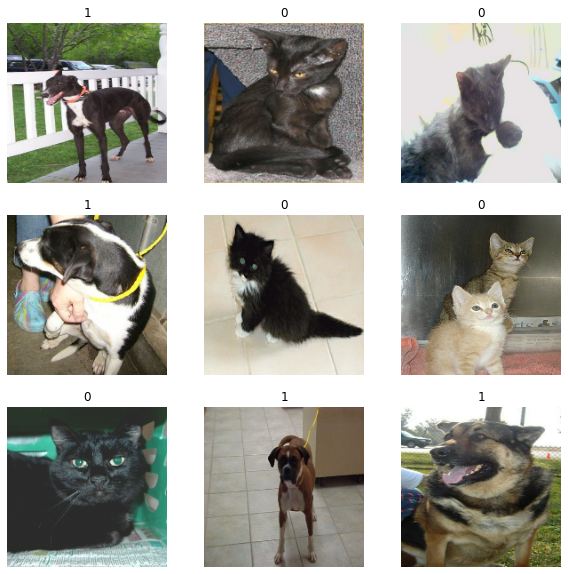

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# Data Augmentation

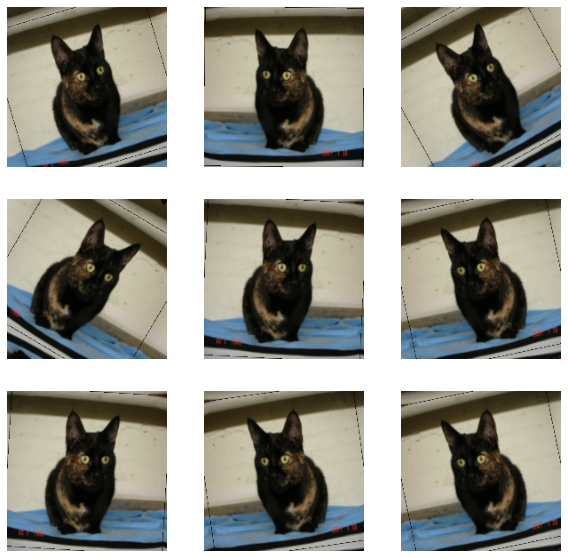

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Optimization (Prefetching)

In [8]:
train_ds = train_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

# Define Model

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f238c3f7b70>, <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f23e6a3e400>, <tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f238c3f7cf8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f238c3f7e10>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f238c367128>, <tensorflow.python.keras.layers.core.Activation object at 0x7f238c367898>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f238c367630>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f238c316320>, <tensorflow.python.keras.layers.core.Activation object at 0x7f238c3169e8>, <tensorflow.python.keras.layers.core.Activation object at 0x7f238c316ba8>, <tensorflow.python.keras.layers.convolutional.SeparableConv2D object at 0x7f238c3317b8>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization o

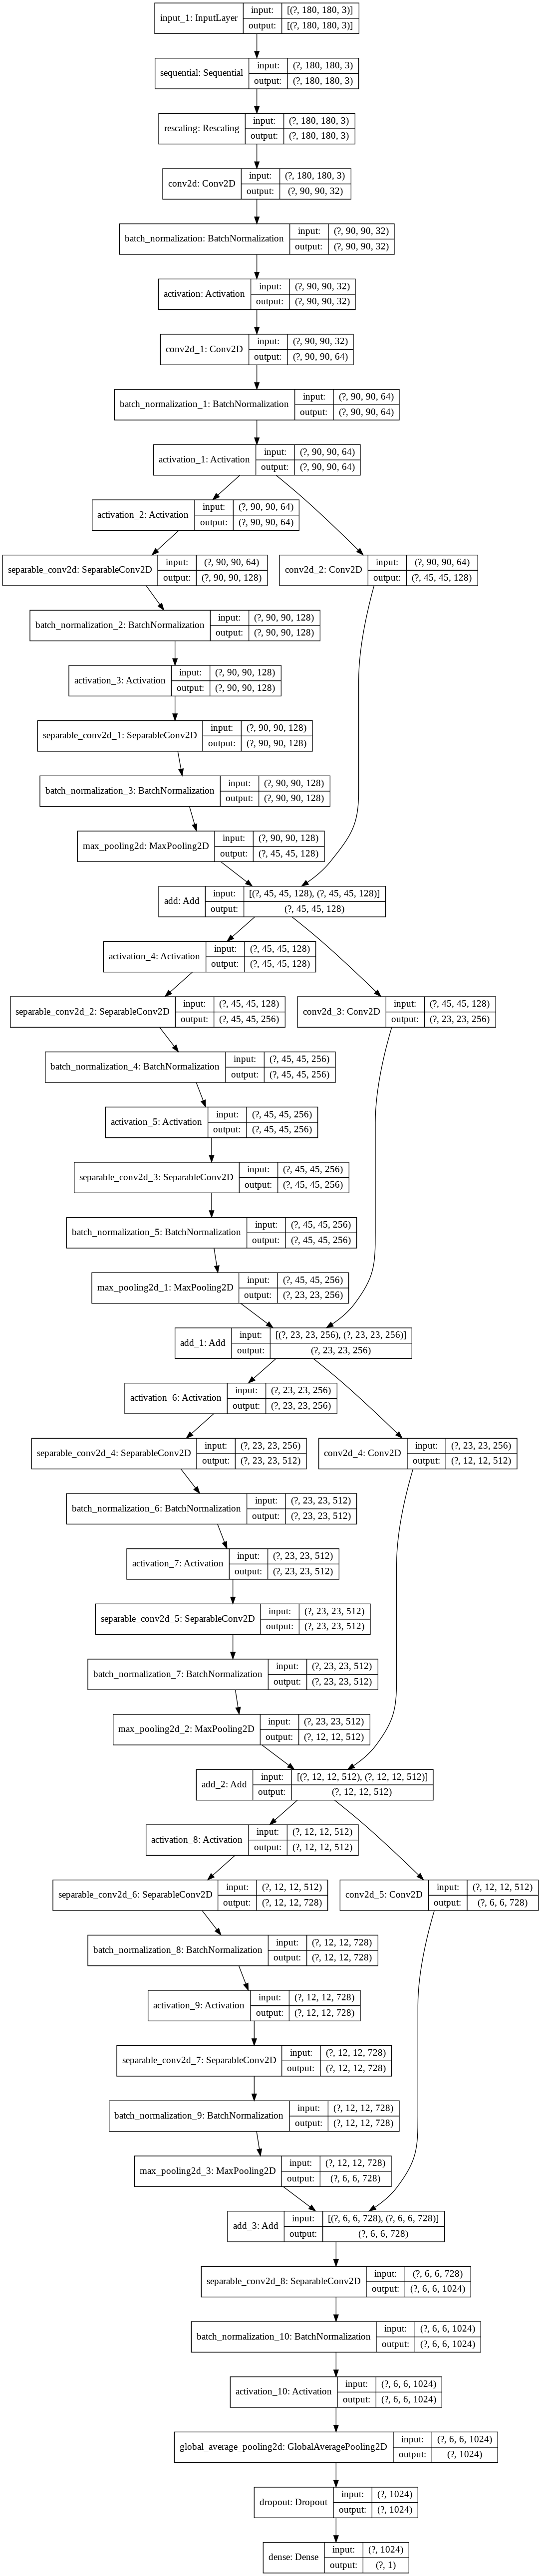

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
print(model.layers, len(model.layers))
keras.utils.plot_model(model, show_shapes=True)

# Train Model

In [10]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
469/469 [==============================] - 123s 263ms/step - loss: 0.6398 - accuracy: 0.6571 - val_loss: 1.5000 - val_accuracy: 0.4962
Epoch 2/10
469/469 [==============================] - 124s 264ms/step - loss: 0.5060 - accuracy: 0.7542 - val_loss: 0.5438 - val_accuracy: 0.7439
Epoch 3/10
469/469 [==============================] - 124s 264ms/step - loss: 0.4235 - accuracy: 0.8046 - val_loss: 0.6289 - val_accuracy: 0.7134
Epoch 4/10
469/469 [==============================] - 124s 263ms/step - loss: 0.3588 - accuracy: 0.8416 - val_loss: 0.3085 - val_accuracy: 0.8665
Epoch 5/10
469/469 [==============================] - 123s 263ms/step - loss: 0.3154 - accuracy: 0.8691 - val_loss: 0.3500 - val_accuracy: 0.8552
Epoch 6/10
469/469 [==============================] - 124s 264ms/step - loss: 0.2712 - accuracy: 0.8826 - val_loss: 0.2431 - val_accuracy: 0.8960
Epoch 7/10
469/469 [==============================] - 124s 264ms/step - loss: 0.2394 - accuracy: 0.9021 - val_loss: 0.2119 -

# Model Outputs

In [2]:
import numpy as np
from keras import backend as K

accuracy_log = list()
activation_log = list()

for i in range(1):
# for i in range(epochs+1):
  # create a new model with same architecture that we did the training on
  dummy_model = make_model(input_shape=image_size + (3,), num_classes=2)

  # for the first iteration, start with a blank model with no learned weights.
  # After that, load in the weights from saved checkpoints at training
  if i > 0:
    weights_str = 'save_at_{checkpoint}.h5'.format(checkpoint=i)
    dummy_model.load_weights(weights_str)

  # compile the model from this checkpoint
  dummy_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                      loss="binary_crossentropy",
                      metrics=["accuracy"])
  loss, acc = dummy_model.evaluate(test_ds)
  accuracy_log.append(acc)

  # test labels vs. images are correct
  for images, labels in test_ds.take(1):
    for i in range(8):
      im = images[i]
      l =  labels[i]
      plt.figure()
      plt.imshow(im.numpy().astype("uint8"))
      plt.title(int(l))

  # get activations for each image in test set
  result_log = list()
  for batch in test_ds:
    images = batch[0]
    labels = batch[1]
    for i in range(labels.shape[0]):
      # extract the image and run a prediction on the current model snapshot
      im = images[i]
      l  = labels[i]
      test_image = im[np.newaxis, :]
      prediction = dummy_model.predict(test_image)

      # get layer activation
      layer_idx = 48
      out_func = K.function([dummy_model.input], [dummy_model.layers[layer_idx].output])
      out_vals = out_func([test_image])[0][0]

      result = (out_vals, l)
      print(int(l))
      result_log.append(result)

    activation_log.append(result_log)

  print(activation_log.shape)

  # take a batch from the test dataset
  # test_batch = test_ds.take(1)
  # for images, labels in test_batch:
  #   print(len(images))
  #   # get a test image from this batch
  #   test_image = images[0]
  #   test_image = test_image[np.newaxis, :]
  #   p = dummy_model.predict(test_image)

  #   # get activations for this image on a specific layer
  #   layer_idx = 48
  #   print(dummy_model.layers[layer_idx])

  #   out_func = K.function([dummy_model.input], [dummy_model.layers[layer_idx].output])
  #   out_val = out_func([test_image])[0]
  #   print(out_val)

  #   plt.figure()
  #   plt.plot(np.sort(out_val[0]))
  #   plt.ylim((0, 1.5))

NameError: ignored

ValueError: ignored

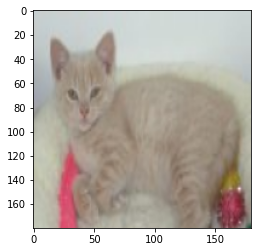

In [211]:
# quick check that prediction makes sense
batch = test_ds.take(1)
for images, labels in batch:
  prediction = dummy_model.predict(images)
  for i in range(4):
    plt.figure()
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title('true: ' + str(int(labels[i])) + ', predicted: ' + str(np.round(prediction[i])))